In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.nddata.utils import Cutout2D
import matplotlib.cm as cm
import matplotlib as mpl
import astropy.units as u
from collections import Counter
import numpy as np 
from keras.models import Sequential #sequential model of layers, as the one explained in this part of the book
from keras.layers.core import Dense, Activation
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [2]:
import warnings
warnings.filterwarnings('ignore')

reading IOUT
scaling...
(480, 480)
IOUT done


reading EOS
scaling...
EOS done


reading rho
scaling...
(480, 256, 480)
rho done


reading vyy
vyy done


reading byy
byy done




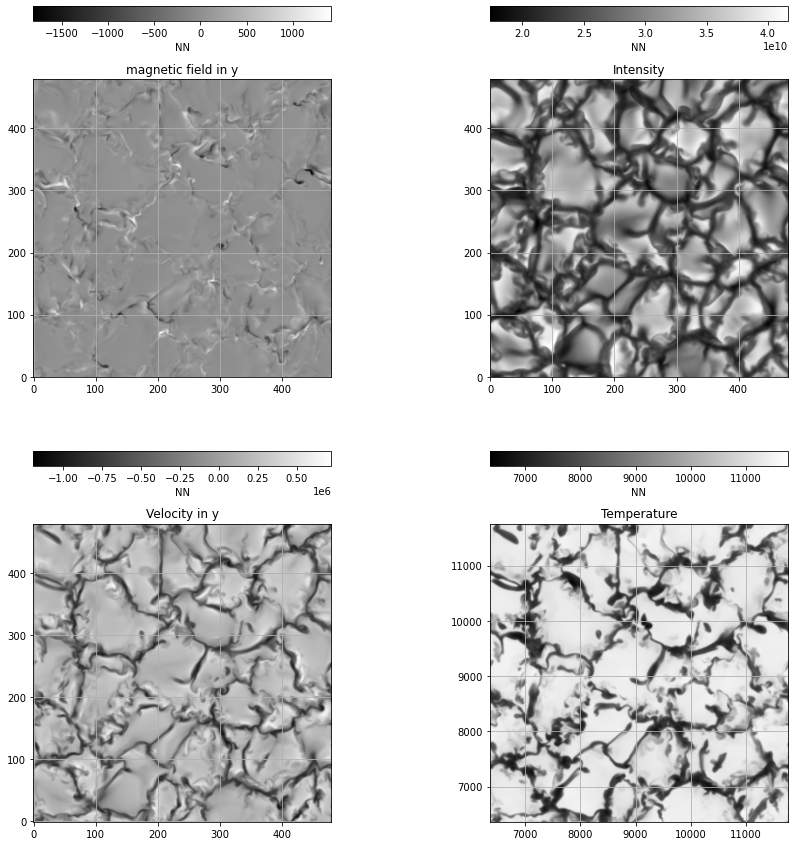

In [4]:
self_ptm = ''
self_filename = '154000'
self_nx = 480
self_ny = 256
self_nz = 480


#Scaling function
def scaling(array):
  scaler = MinMaxScaler()
  array1 = array.reshape(-1,1)
  scaler.fit(array1)
  array1 = scaler.transform(array1)
  array1 = np.ravel(array1)
  return array1

################################
# Charging the data into the code - every data is converted into a cube 
# of data so that it has the form of the dominium of the simulation
#
# The lines of the code for mvxx, mvyy, mbxx and mbyy are commented beacuse
# we are not interested in ploting this magnitudes for the image analysis 
# we are going to make
#
# The temperature is obtained from the data file related to the 
# equation of state (EOS)
################################

print("reading IOUT")
self_iout = np.fromfile(self_ptm+"iout."+self_filename,dtype=np.float32)
self_iout = np.reshape(self_iout, (self_nx, self_nz), order="A")
print("scaling...")
self_iout_scaled = scaling(self_iout) #scaled intensity
self_iout_scaled = np.reshape(self_iout_scaled, (self_nx, self_nz), order="A")
print(np.shape(self_iout))
print("IOUT done")   
print('\n')

print("reading EOS")
self_mtpr = np.fromfile(self_ptm+"eos."+self_filename,dtype=np.float32)
self_mtpr = np.reshape(self_mtpr, (2, self_nx,self_ny,self_nz), order="A")
n_eos = 0
self_mtpr = self_mtpr[n_eos,:,:,:] 
print("scaling...")
self_mtpr_scaled = scaling(self_mtpr)
self_mtpr_scaled = np.reshape(self_mtpr_scaled, (self_nx,self_ny,self_nz), order="A")
# n_eos -> 0: temperature ; 1: pressure
print("EOS done")
print('\n')

print("reading rho")
self_mrho = np.fromfile(self_ptm+"result_0."+self_filename,dtype=np.float32)
self_mrho = np.reshape(self_mrho, (self_nx,self_ny,self_nz), order="A")
print("scaling...")
self_mrho_scaled = np.log10(self_mrho) #I get the logarithm in base 10 out of the density values so that the big valued data does not damage the code
self_mrho_scaled = scaling(self_mrho)
self_mrho_scaled = np.reshape(self_mrho_scaled, (self_nx,self_ny,self_nz), order="A")
print(np.shape(self_mrho))
print("rho done")
print('\n')

#         print("reading vxx")
#         self.mvxx = np.fromfile(self.ptm+"result_1."+self.filename,dtype=np.float32)
#         self.mvxx = np.reshape(self.mvxx,(self.nx,self.nz,self.ny),order="C")
#         print("vxx done")

print("reading vyy")
self_mvyy = np.fromfile(self_ptm+"result_2."+self_filename,dtype=np.float32)
self_mvyy = np.reshape(self_mvyy,(self_nx,self_ny,self_nz),order="C")
print("vyy done")
print('\n')
#         print("reading vzz")
#         self.mvzz = np.fromfile(self.ptm+"result_3."+self.filename,dtype=np.float32)
#         self.mvzz = np.reshape(self.mvzz,(self.nx,self.nz, self.ny),order="A")
#         print(np.shape(self.mvzz))
#         print("vzz done")

#     print("reading eps")
#     self.eps = np.fromfile(self.ptm+"result_4."+self.filename,dtype=np.float32)
#     self.eps = np.reshape(self.eps,(self.nx,self.nz,self.ny),order="C")
#     print("eps done")

#         print("reading bxx")
#         self.mbxx = np.fromfile(self.ptm+"result_5."+self.filename,dtype=np.float32)
#         self.mbxx = np.reshape(self.mbxx,(self.nx,self.nz,self.ny),order="C")
#         print("bxx done")

print ("reading byy")
self_mbyy = np.fromfile(self_ptm+"result_6."+self_filename,dtype=np.float32)
self_mbyy = np.reshape(self_mbyy,(self_nx,self_ny,self_nz),order="C")
print("byy done")
print('\n')

#         print("reading bzz")
#         self.mbzz = np.fromfile(self.ptm+"result_7."+self.filename,dtype=np.float32)
#         self.mbzz = np.reshape(self.mbzz,(self.nx,self.nz, self.ny),order="A")
#         print(np.shape(self.mbzz))
#         print("bzz done")

#############################################################
#Converting the data into cgs units (if I'm not wrong)
#############################################################

#         self.mvxx=self.mvxx/self.mrho
self_mvyy=self_mvyy/self_mrho
self_mvyy_scaled = scaling(self_mvyy)
self_mvyy_scaled = np.reshape(self_mvyy_scaled,(self_nx,self_ny,self_nz),order="C")
#         self.mvzz=(self.mvzz/self.mrho)*-6e10
coef = np.sqrt(4.0*np.pi)
#         self.mbxx=self.mbxx*coef
self_mbyy=self_mbyy*coef
self_mbyy_scaled = scaling(self_mbyy)
self_mbyy_scaled = np.reshape(self_mbyy_scaled,(self_nx,self_ny,self_nz),order="C")
#         self.mbzz=self.mbzz*coef


#############################################################
# Here we select the slices for a nz=cte so that we obtain the 2d graphs of 
# the intensity, temperature, magnetic field in z and velocity in z
#############################################################v

plot_mbyy, plot_iout, plot_mvyy, plot_mrho, plot_mtpr, plot_eps = np.zeros((self_nx, self_nz)), np.zeros((self_nx, self_nz)), np.zeros((self_nx, self_nz)), np.zeros((self_nx, self_nz)), np.zeros((self_nx, self_nz)), np.zeros((self_nx, self_nz))

ny_slice = 170

#         for i in range(np.shape(self.mbzz)[0]):
plot_mbyy = self_mbyy[:,ny_slice,:]
plot_mvyy = self_mvyy[:,ny_slice,:]
plot_mtpr = self_mtpr[:,ny_slice,:]
#     plot_eps = self.eps[:,nz_slice,:]
plot_iout = self_iout


#         plot_iout = np.reshape(plot_iout, (self.nx, self.ny))
#         plot_mbzz = np.reshape(plot_mbzz, (np.shape(self.mbzz)[2], np.shape(self.mbzz)[2]))
#         plot_mvzz = np.reshape(plot_mvzz, (np.shape(self.mvzz)[2], np.shape(self.mvzz)[2]))
#         plot_mtpr = np.reshape(plot_mtpr, (np.shape(self.mtpr)[0], np.shape(self.mtpr)[2]))
#         plot_eps = np.reshape(plot_eps, (np.shape(self.eps)[0], np.shape(self.eps)[2]))

#############################################################
# Here we plot the 2D graphs using Matplotlib
#############################################################

f = plt.figure(figsize=(15,15))

ax1 = f.add_subplot(221)
by = ax1.imshow(plot_mbyy, cmap='gist_gray', origin='lower')
ax1.set_title('magnetic field in y')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('top', size='5%', pad=0.8)
f.colorbar(by, cax=cax1, orientation="horizontal", label="NN")
ax1.grid()

ax2 = f.add_subplot(222)
surf = ax2.imshow(plot_iout, cmap='gist_gray', origin='lower')
ax2.set_title('Intensity')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('top', size='5%', pad=0.8)
f.colorbar(surf, cax=cax2, orientation="horizontal", label="NN")
ax2.grid()

ax3 = f.add_subplot(223)
divider3 = make_axes_locatable(ax3)
vy = ax3.imshow(plot_mvyy, cmap='gist_gray', interpolation='gaussian', origin='lower')
cax3 = divider3.append_axes('top', size='5%', pad=0.8)
ax3.set_title('Velocity in y')
f.colorbar(vy, cax=cax3, orientation="horizontal", label="NN")
ax3.grid()

ax4 = f.add_subplot(224)

divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes('top', size='5%', pad=0.8, label='a')
data = plot_mtpr
extent = (np.min(data), np.max(data), np.min(data), np.max(data))
position = (0,0)      
#         size = u.Quantity((720, 720), u.pixel)
#         cutout = Cutout2D(data, position, size, mode='trim')
tem = ax4.imshow(data, origin='lower',   cmap='gist_gray', interpolation='gaussian', vmax=np.max(data), extent=extent)
ax4.set_title('Temperature')
f.colorbar(tem, cax=cax4, orientation="horizontal", label="NN")
ax4.grid()

#     ax5 = f.add_subplot(235)
#     eps = ax5.imshow(plot_eps, cmap='gist_gray', origin='lower')
#     ax5.set_title('eps')
#     divider5 = make_axes_locatable(ax5)
#     cax5 = divider5.append_axes('top', size='5%', pad=0.8)
#     f.colorbar(eps, cax=cax5, orientation="horizontal", label="NN")
#     ax5.grid()


plt.savefig("test1")
plt.show()

#############################################################
# This functions are just for some testing, but are not part 
# of the main code
#############################################################

def make_box(Npx, **kwargs):
    """Draws a box containing Npx pixels in center of an image"""
    box_size = Npx
    box_halflen = np.ceil(np.sqrt(box_size)/2.)
    mid_pix = plot_iout.shape[0] / 2
    box_halflen, mid_pix
    box = mpl.patches.Rectangle( (mid_pix - box_halflen, mid_pix - box_halflen),
                               2*box_halflen, 2*box_halflen, fill=False, **kwargs)
    return box

imparams = dict(origin='lower', interpolation='bicubic')
sequential = dict(**imparams, cmap='inferno')
diverging = dict(**imparams, cmap='seismic_r')
magnetogram = dict(**imparams, cmap='gray')

def add_boxes(ax, **kwargs):
    """Adds boxes to an axis"""
    # dashed lines: boxes containing 1e5, 1e6 pixels
    for i in (1, 10):
        ax.add_patch(make_box(i*1e5, **kwargs, ls='--'))
    # solid lines: boxes containing 2**n * 1e5 pixels
    for i in (2, 4, 8, 16):   
        ax.add_patch(make_box(i*1e5, **kwargs))




In [6]:
tr_div_nx = 300
tr_div_nz = 480

te_div_nx = 100
te_div_nz = 480

pr_div_nx = 80
pr_div_nz = 480

#DIVIDING THE DATA WE WANT TO CLASIFFY AND ITS LABELS - It is being used the 
#scaled data

data = np.array([self_mbyy_scaled,
            self_mvyy_scaled,
            self_mtpr_scaled,
            self_mrho_scaled])

labels = self_iout_scaled


print(np.shape(data))
print(np.shape(labels))


#TRAINING SET AND DATA SET
tr_data = []
tr_labels = []
#Here I'm dividing the whole data for the nx, nz dimensions. The first half is the training set and the second half is the test set
for j in range(tr_div_nx):
    for k in range(tr_div_nz):
        tr_data.append([data[0][j,:,k], 
                       data[1][j,:,k],
                       data[2][j,:,k],
                       data[3][j,:,k]]) #It puts the magnetic field, velocity, temperature and density values in one row for 240x240=57600 columns
        tr_labels.append(labels[j,k]) #the values from the column of targets
        
tr_data = np.array(tr_data)   
tr_labels = np.array(tr_labels)  

print('\n training data shape')
print(np.shape(tr_data))
print('\n training labels shape')
print(np.shape(tr_labels))

te_data = []
te_labels = []
for j in range(te_div_nx):
    for k in range(te_div_nz):
        te_data.append([data[0][tr_div_nx+j,:,k], 
                       data[1][tr_div_nx+j,:,k],
                       data[2][tr_div_nx+j,:,k],
                       data[3][tr_div_nx+j,:,k]]) #It puts the magnetic field, velocity, temperature and density values in one row for 240x240=57600 columns
        te_labels.append(labels[tr_div_nx+j,k]) #the values from the column of targets

te_data = np.array(te_data)   
te_labels = np.array(te_labels)  


print('\n test data shape')
print(np.shape(te_data))
print('\n test labels shape')
print(np.shape(te_labels))
print('\n')


pr_data = []
pr_labels = []
pr_trans = tr_div_nx + te_div_nx
for j in range(pr_div_nx):
    for k in range(pr_div_nz):
        pr_data.append([data[0][pr_trans+j,:,k], 
                       data[1][pr_trans+j,:,k],
                       data[2][pr_trans+j,:,k],
                       data[3][pr_trans+j,:,k]]) #It puts the magnetic field, velocity, temperature and density values in one row for 240x240=57600 columns
        pr_labels.append(labels[pr_trans+j,k]) #the values from the column of targets




pr_data = np.array(pr_data)    
pr_labels = np.array(pr_labels)  

print('\n predict data shape')
print(np.shape(pr_data))
print('\n predict labels shape')
print(np.shape(pr_labels))
print('\n')


model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(128, 2, activation='relu', input_shape=(4, 256)))
model.add(tf.keras.layers.Conv1D(64, 2, activation='relu'))
model.add(tf.keras.layers.Conv1D(32, 2, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPool1D())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3)) #Layer added to avoid the overfitting
model.add(tf.keras.layers.Dense(1))
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mse'],
)

BATCH_SIZE = int(tr_div_nx*tr_div_nz/10)
# print()
model.fit(tr_data, tr_labels, batch_size=BATCH_SIZE, epochs=15)

#TESTING
print('\n *TEST*')
metrics = model.evaluate(te_data, te_labels, verbose=1)
print("%s: %2.f%%" % (model.metrics_names[1], metrics[1]*100))

model.summary()

pr_BATCH_SIZE = int(len(pr_data)/10)
print(pr_BATCH_SIZE)


intensity_out = model.predict(pr_data, batch_size=10, verbose=1)
intensity_out = intensity_out.reshape(pr_div_nx, pr_div_nz)
print(np.shape(intensity_out))
pr_labels = pr_labels.reshape(pr_div_nx, pr_div_nz)

(4, 480, 256, 480)
(480, 480)

 training data shape
(144000, 4, 256)

 training labels shape
(144000,)

 test data shape
(48000, 4, 256)

 test labels shape
(48000,)



 predict data shape
(38400, 4, 256)

 predict labels shape
(38400,)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 128)            65664     
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             16448     
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 32)             4128      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense) 

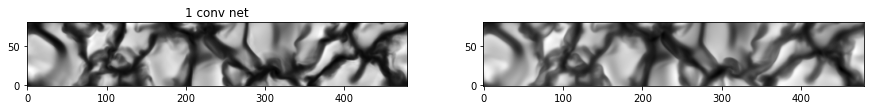

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].imshow(intensity_out, cmap = 'gist_gray', origin='lower')
ax[0].set_title('1 conv net')
ax[1].imshow(pr_labels, cmap='gist_gray', origin='lower')
plt.show()